In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [2]:
dt = pd.read_csv('heart.csv')


In [3]:
dt.info()
dt.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   
5   57    1   0       140   192    0        1      148      0      0.4      1   
6   56    0   1       140   294    0        0      153      0      1.3      1   
7   44    1   1       120   263    0        1      173      0      0.0      2   
8   52    1   2       172   199    1        1      162      0      0.5      2   
9   57    1   2       150   168    0        1      174      0      1.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
5   0     1       1  
6   0     2       1  
7   0     3       1  
8   0     3       1  
9   0     2       1

In [4]:
dt.describe()

age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

             thal      target  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

In [5]:
dt.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [6]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [7]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

In [8]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [9]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [10]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [11]:
dt.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [12]:
countNoDisease = len(dt[dt.target == 0])
countHaveDisease = len(dt[dt.target == 1])
print("Percentage of Patients Haven't Heart Disease: {:.2f}%".format((countNoDisease / (len(dt.target))*100)))
print("Percentage of Patients Have Heart Disease: {:.2f}%".format((countHaveDisease / (len(dt.target))*100)))

Percentage of Patients Haven't Heart Disease: 45.54%
Percentage of Patients Have Heart Disease: 54.46%


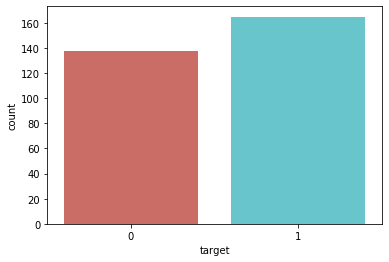

In [13]:
sns.countplot(x='target', data= dt, palette = 'hls')
plt.show()

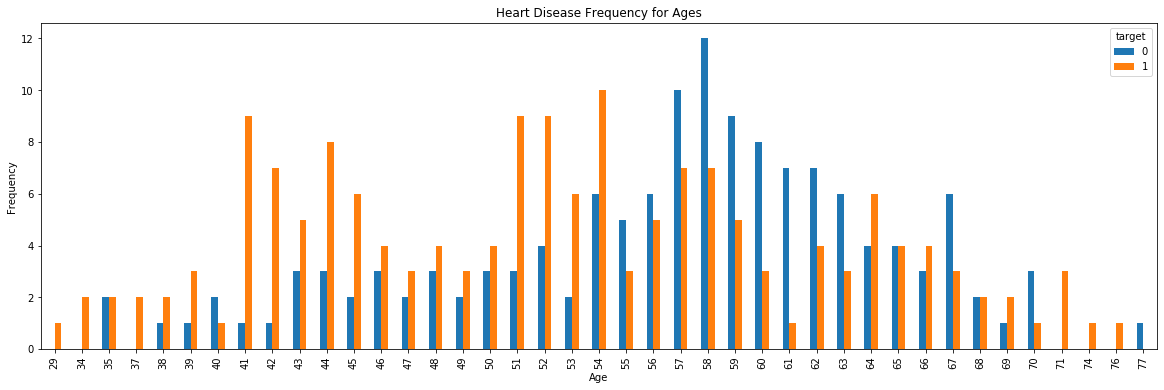

In [14]:
pd.crosstab(dt.age,dt.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('heartDiseaseAndAges.png')
plt.show()

In [15]:
dt = pd.get_dummies(dt, drop_first=True)

In [16]:
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   37                     130          250                      187   
2   41                     130          204                      172   
3   56                     120          236                      178   
4   57                     120          354                      163   

   st_depression  num_major_vessels  target  sex_male  \
0            2.3                  0       1         1   
1            3.5                  0       1         1   
2            1.4                  0       1         0   
3            0.8                  0       1         1   
4            0.6                  0       1         0   

   chest_pain_type_atypical angina  chest_pain_type_non-anginal pain  \
0                                0                                 1   
1                                1                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   chest_pain_type_typical angina  fasting_blood_sugar_lower than 120mg/ml  \
0                               0                                        0   
1                               0                                        1   
2                               1                                        1   
3                               1                                        1   
4                               0                                        1   

   rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
0                                      0                1   
1                                      0                0   
2                                      0                1   
3                                      0                0   
4                                      0                0   

   exercise_induced_angina_yes  st_slope_flat  st_slope_upsloping  \
0                            0              0                   0   
1                            0              0                   0   
2                            0              1                   0   
3                            0              1                   0   
4                            1              1                   0   

   thalassemia_fixed defect  thalassemia_normal  thalassemia_reversable defect  
0                         0                   1                              0  
1                         1                   0                              0  
2                         1                   0                              0  
3                         1                   0                              0  
4                         1                   0                              0

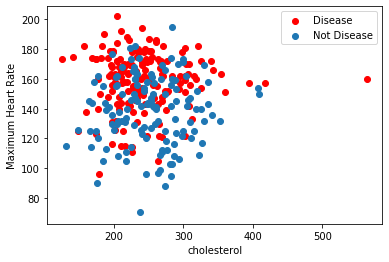

In [17]:
plt.scatter(x=dt.cholesterol[dt.target==1], y=dt.max_heart_rate_achieved[(dt.target==1)], c="red")
plt.scatter(x=dt.cholesterol[dt.target==0], y=dt.max_heart_rate_achieved[(dt.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("cholesterol")
plt.ylabel("Maximum Heart Rate")
plt.show()

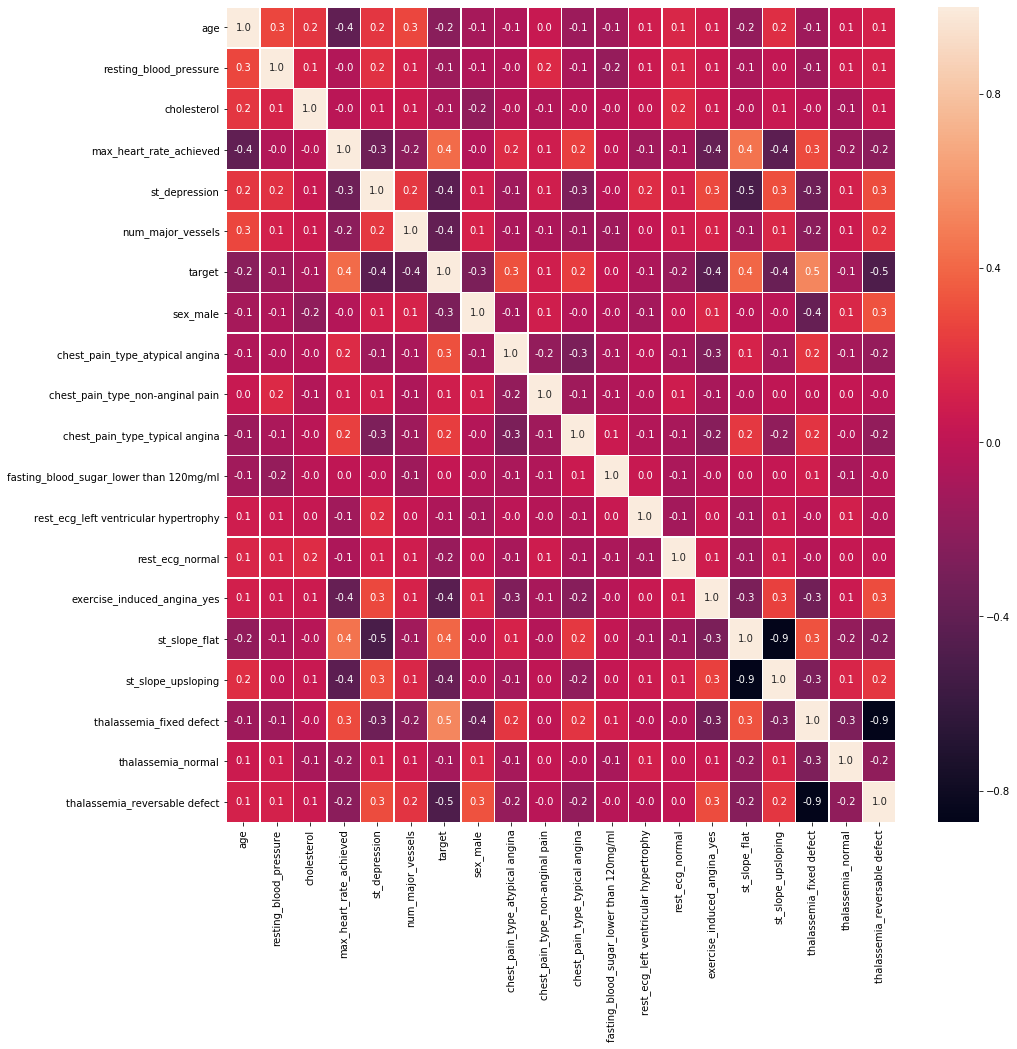

In [18]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(dt.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

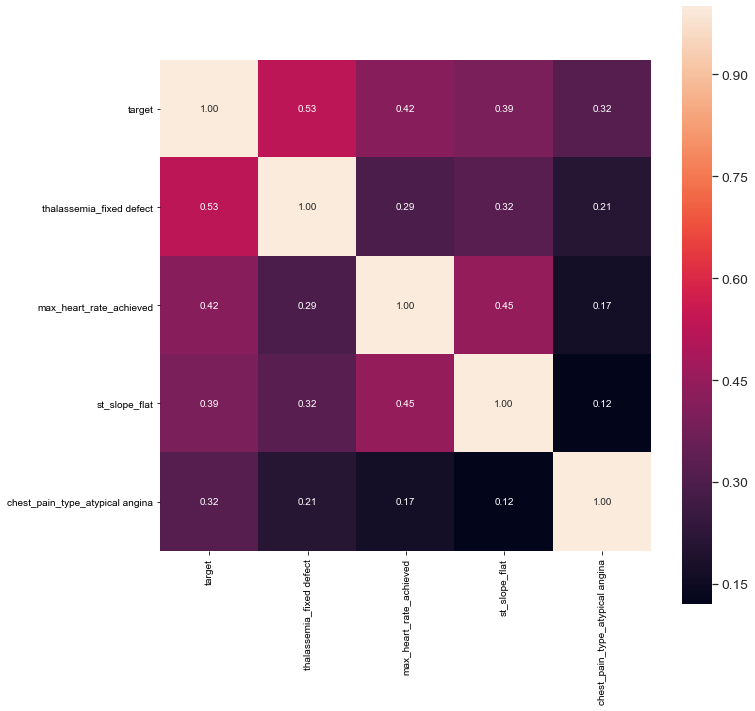

In [19]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = dt.corr().nlargest(k, 'target')['target'].index
cm = np.corrcoef(dt[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

In [21]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [23]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

In [24]:
y_predict = model.predict(X_test)
print(y_predict)
y_pred_quant = model.predict_proba(X_test)[:, 1]
print(y_pred_quant)
y_pred_bin = model.predict(X_test)
print(y_pred_bin)

[0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1]
[0.11714286 0.35507246 0.16785714 0.70238756 0.18443651 0.89120336
 0.61660957 0.78051943 0.94471832 0.05119048 0.95805165 0.00555556
 0.82286375 0.99152778 0.30444444 0.86236715 0.17896825 0.00952381
 0.71362319 0.25015183 0.12380952 0.86846541 0.57430188 0.92186813
 0.35191198 0.08952381 0.00952381 0.16857864 0.81827624 0.
 0.80248677 0.30729469 0.2        0.51124622 0.00952381 0.06459627
 0.56661679 0.46138889 0.92080026 0.38873016 0.         0.34235335
 0.92829232 0.42047619 0.97180165 0.18886364 0.54285714 0.8552378
 0.91319444 0.31014493 0.6375     0.74885046 0.02564103 0.24788199
 0.96872804 0.85123769 0.78472222 0.8238947  0.00952381 0.01428571
 0.71849332]
[0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1]


In [25]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[28,  7],
       [ 3, 23]])

In [26]:
from sklearn.metrics import accuracy_score
total=sum(sum(confusion_matrix))

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('precision : ', precision )

recall = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('recall : ', recall)
accuracy_score(y_test,y_pred_bin)

precision :  0.9032258064516129
recall :  0.7666666666666667


0.8360655737704918

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bin))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85        35
           1       0.77      0.88      0.82        26

    accuracy                           0.84        61
   macro avg       0.83      0.84      0.83        61
weighted avg       0.85      0.84      0.84        61



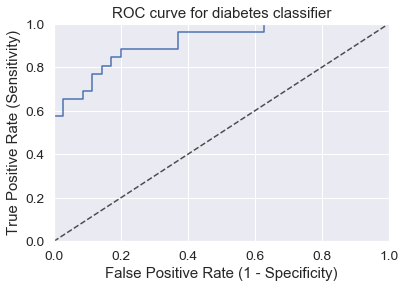

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [29]:
auc(fpr, tpr)

0.9131868131868132

In [30]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

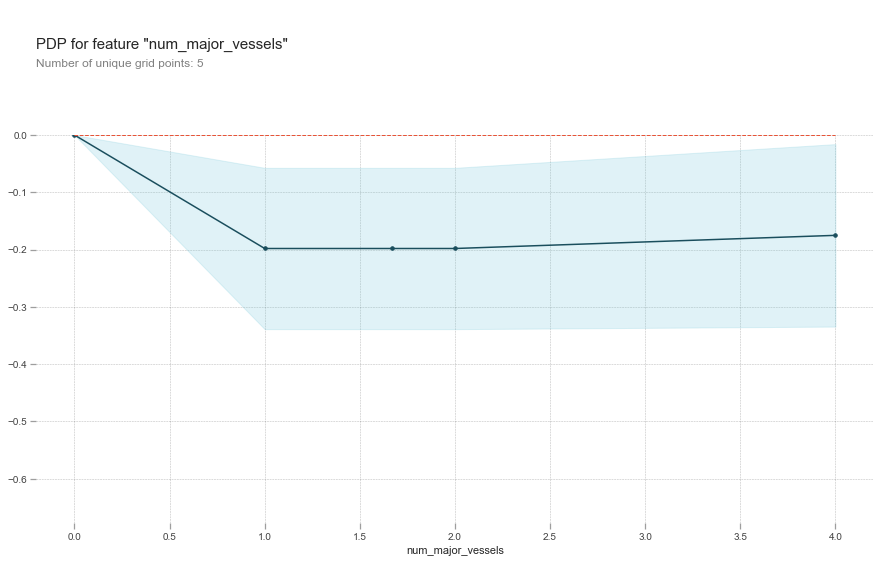

In [31]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test_log = train_test_split(dt.drop('target', 1), dt['target'], test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred_log = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test_log)))

Accuracy of logistic regression classifier on test set: 0.85


In [34]:
"""
confusion_matrix2 = confusion_matrix(y_test_log, y_pred_log)
print(confusion_matrix2)
"""

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
"""
total=sum(sum(confusion_matrix2))

precision = confusion_matrix2[0,0]/(confusion_matrix2[0,0]+confusion_matrix2[1,0])
print('precision : ', precision )

recall = confusion_matrix2[1,1]/(confusion_matrix2[1,1]+confusion_matrix2[0,1])
print('recall : ', recall)
"""

In [35]:
print(classification_report(y_test_log, y_pred_log))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        27
           1       0.86      0.88      0.87        34

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

